# Working with Maps
## Extracting Features for Traffic Crash Insights

### Jenny Turner-Trauring


# So you want to work with maps

- You might have one map for a single city
- You might have other geographical data, but you might not have a map
- You might want to combine geographical data from several data sources
- You might even want to add additional maps

For Insight Lane, we want any city to be able to use our tools, and so we use maps from OpenStreetMap as the base map

Then we can add other types of geographic features


# OpenStreetMap

OpenStreetMap is a free, open, crowdsourced map of the world

<table><tr><td><img src='osm_list.png'></td><td><img src='osm_central.png'></td></tr></table>


Lots of 3rd party services use openstreetmap

There are many more features from open street maps alone that we plan to incorporate, including (but certainly not limited to) crosswalks, stop signs, bike and pedestrian facilities, turning restrictions, dedicated turn lanes, bus stops, and school zones.



# Getting data from OpenStreetMap
- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) - read only API for accessing OpenStreetMap data
- [osmnx](https://github.com/gboeing/osmnx) is a python package that allows users to easily download OpenStreetMap data 
    - Easily download street networks for specific cities
    - Can write resulting road network to shapefiles
    - [osmnx tutorial](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)


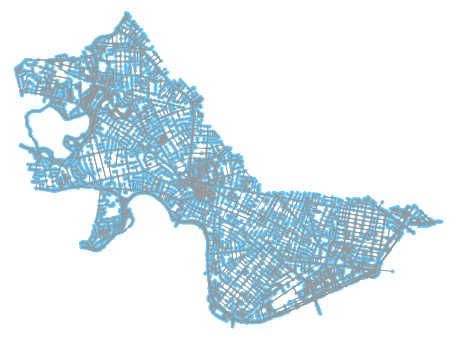

(<Figure size 793.509x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1097bf1da0>)

In [2]:
import osmnx as ox
G1 = ox.graph_from_place('Cambridge, Massachusetts, USA', simplify=False)
ox.plot_graph(G1)

# If there's no city boundary defined
- We can get data within a radius, or within a polygon
- Let's look at Central Square in Cambridge, Massachusetts

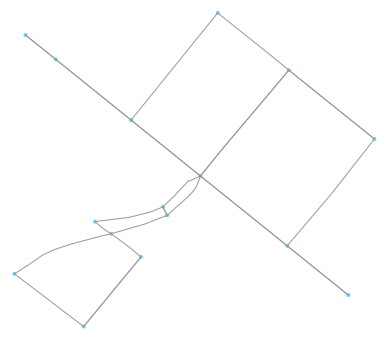

In [5]:
G2 = ox.graph_from_point((42.365572, -71.104034), distance=150, network_type='drive')
ox.plot_graph(G2)

ox.save_graph_shapefile(G2)

# Unsimplified network
- graph_from_point simplifies the network, but you might want to look at the umsimplified network
- This still removes all nodes that aren't part of the road network

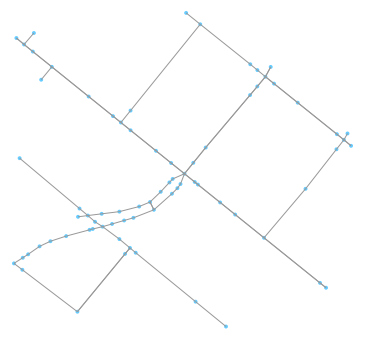

(<Figure size 628.537x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f393b3c2ef0>)

In [6]:
G3 = ox.graph_from_point((42.365572, -71.104034), distance=150, network_type='drive', simplify=False)
ox.plot_graph(G3)

# Tags
- OpenStreetMap uses tags for describing features of elements
- Tags consist of key value pairs
- Some nodes have a highway tag (signals, stop signs, crosswalks)

In [34]:
import geopandas
nodes, data = zip(*G1.nodes(data=True))
gdf_nodes = geopandas.GeoDataFrame(list(data), index=nodes)
print("{} traffic signals".format(len(gdf_nodes[gdf_nodes['highway'] == 'traffic_signals'])))
print("{} stop signs".format(len(gdf_nodes[gdf_nodes['highway'] == 'stop'])))

260 traffic signals
6 stop signs


# SIX stop signs??


- Road networks in OpenStreetMap generally are quite good
- Some other features are only as good as the crowdsourcing


Are the traffic signals any good?

In [38]:
import fiona
data = fiona.open('TRAFFIC_Signals.shp')
print("{} traffic signals from Cambridge's Open Data Portal".format(len(data)))
print("{} traffic signals from OpenStreetMap".format(len(gdf_nodes[gdf_nodes['highway'] == 'traffic_signals'])))

175 traffic signals from Cambridge's Open Data Portal
260 traffic signals from OpenStreetMap


We'll look into this in a bit

# Postprocessing
- osmnx's save_graph_shapefile writes ways and nodes in ESRI shapefile format
- Can also write to osm xml file or GraphML
- We postprocess to geojson format

# Creating intersections and non-intersection segments
- Based on Azavea's [algorithm](https://www.azavea.com/blog/2016/10/05/philippines-road-safety-using-shapely-fiona-locate-high-risk-traffic-areas/)


<img src='elements.png'  style="width: 30%; float:right;">
<ul style="width: 60%;">
    <li>Roads are OpenStreetMap ways
    <li>Intersections are remaining nodes after osmnx simplification and dropping dead ends</ul>


<img src='buffered.png'  style="width: 30%; float:right;">
<ul style="width: 60%;">
    <li>Create a 20 meter buffer around each intersection
    <li>Merge overlapping buffers</ul>


<table><tr><td><img src='inters.png'></td><td><img src='non_inters.png'></td></tr></table>

# Projections
- Most open data is in EPSG:4326, e.g. 
- EPSG:3857 (Pseudo-Mercator) projects WGS84 onto a square
- Store data in EPSG:4326 but display and compute in EPGS:3857
- Reference [here](https://lyzidiamond.com/posts/4326-vs-3857)

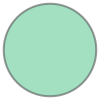

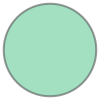

In [23]:
import fiona
import data.util
from shapely.geometry import LineString, Point, MultiLineString
from shapely.ops import unary_union
roads, inters = data.util.get_roads_and_inters('proj_example.geojson')
#data = fiona.open('proj_example.geojson')
#MultiLineString([x.geometry for x in roads])
#foo = [x for x in data]
#LineString(foo[0]['geometry']['coordinates']).intersects(Point(foo[-1]['geometry']['coordinates']))
inters[0]['geometry'].buffer(20)
#inters[0]['geometry'].xy
inters[0]['geometry'].intersects(roads[0].geometry)

buff = [intersection['geometry'].buffer(20) for intersection in inters]
buffered_intersections = unary_union(buff)
foo = MultiLineString([x.geometry for x in roads])
unary_union([buffered_intersections, foo])
display(buff[0])
display(buff[1])



# Going back to traffic signals
- Now that we have created road segments, we can dig deeper into our intersection mismatch

# So now what?
- We have our segments
- We have segment level features from OpenStreetMap
- What else should we add?

# We can add any point-based data
- Traffic signals
- Vision Zero portal data
- See Click Fix or 311 data
- Parking tickets?

In [18]:
import data.util
results, _ = data.util.read_segments('/home/jenny/crash-model/data/cambridge/processed/maps')
foo = [x for x in results if x.properties['parking_tickets']]
len(results)

Read in 23 intersection, 51 non-intersection segments


74

# We can also add features from other maps
- Example: adding a map from Boston

# Interesting features

# Data limitations

# Equity concerns

# Insight Lane's crash model

# Contact
- jenineturner@gmail.com
- [https://github.com/j-t-t](https://github.com/j-t-t)
- [https://insightlane.org](https://insightlane.org)
- [https://github.com/Data4Democracy/crash-model](https://github.com/Data4Democracy/crash-model)